## Domain Token Frequency Analysis

Extract chemistry/materials science domain-relevant tokens from the dataset and calculate frequencies.
Filter out common English stopwords and keep only:
- Chemical formulas (e.g., TiO2, NaOH)
- Element symbols (e.g., Cu, Fe, Ni)
- Domain-specific terms (synthesis, nanoparticles, spectroscopy, etc.)

In [1]:
# Load pre-computed token frequencies
import json

with open('domain_token_frequencies.json', 'r') as f:
    token_freq = json.load(f)

print(f'Total unique domain-relevant tokens: {len(token_freq):,}')
print(f'Total token occurrences: {sum(token_freq.values()):,}')

# Top 30 tokens
print('\n=== TOP 30 DOMAIN-RELEVANT TOKENS ===')
sorted_tokens = sorted(token_freq.items(), key=lambda x: x[1], reverse=True)
for i, (token, count) in enumerate(sorted_tokens[:30], 1):
    print(f'{i:3}. {token:<25} {count:>8,}')

Total unique domain-relevant tokens: 42,525
Total token occurrences: 2,057,890

=== TOP 30 DOMAIN-RELEVANT TOKENS ===
  1. solution                    39,274
  2. spectroscopy                24,039
  3. electron                    23,665
  4. microscopy                  19,693
  5. acid                        19,107
  6. deposition                  17,822
  7. SEM                         16,501
  8. nanoparticles               16,223
  9. powder                      15,752
 10. chemical                    15,001
 11. H2O                         14,646
 12. xrd                         14,599
 13. Co                          14,364
 14. oxide                       13,360
 15. diffraction                 13,124
 16. Cu                          12,615
 17. precursor                   12,285
 18. ethanol                     12,215
 19. films                       11,733
 20. electrochemical             11,498
 21. thermal                     11,459
 22. metal                       10,989
 2

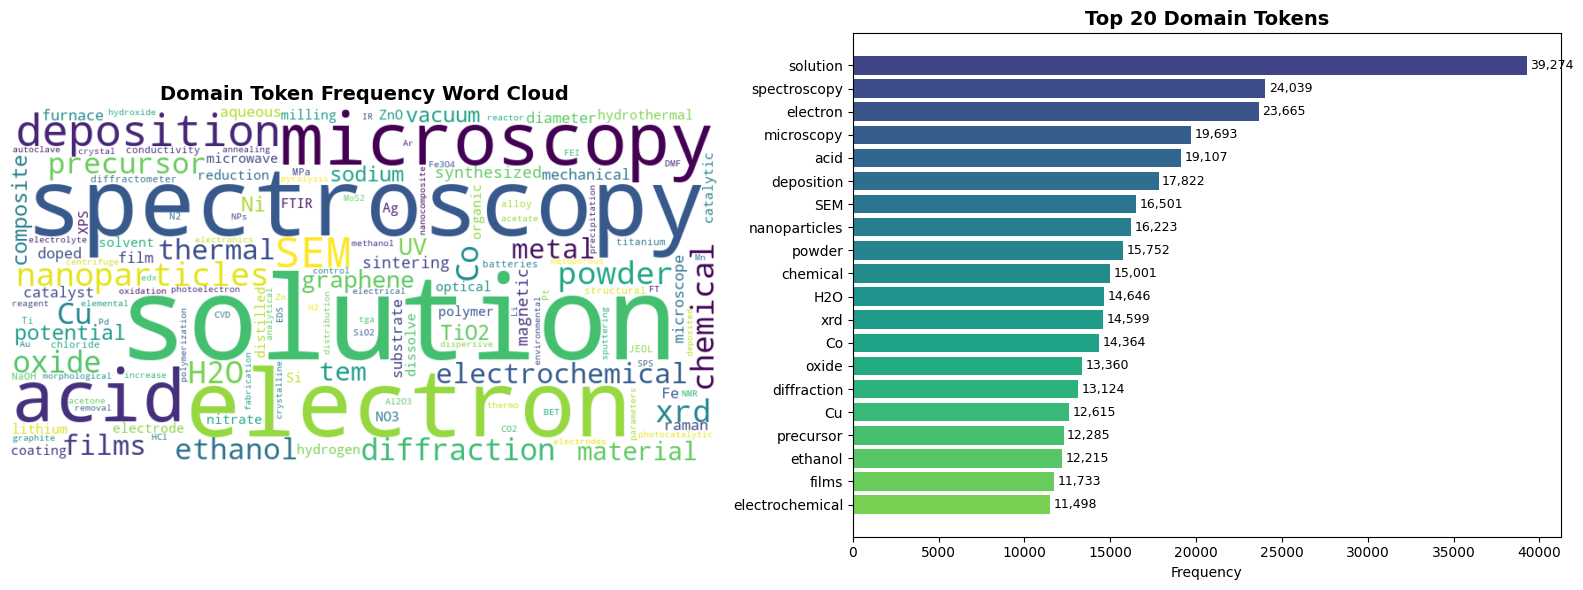

In [4]:
# Visualize top tokens
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Word Cloud
wc = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='viridis',
    max_words=150,
    min_font_size=8,
).generate_from_frequencies(token_freq)

axes[0].imshow(wc, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Domain Token Frequency Word Cloud', fontsize=14, fontweight='bold')

# Bar chart (top 20)
top_20 = sorted_tokens[:20]
tokens = [t[0] for t in top_20]
counts = [t[1] for t in top_20]

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(tokens)))
axes[1].barh(range(len(tokens)), counts, color=colors)
axes[1].set_yticks(range(len(tokens)))
axes[1].set_yticklabels(tokens)
axes[1].invert_yaxis()
axes[1].set_xlabel('Frequency')
axes[1].set_title('Top 20 Domain Tokens', fontsize=14, fontweight='bold')

# Add value labels
for i, v in enumerate(counts):
    axes[1].text(v + 200, i, f'{v:,}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('domain_token_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## Embedding & Similarity (MatBERT vs RoBERTa)

- 42,525개 유니크 도메인 토큰(`domain_token_frequencies.json`)에 대해 MatBERT 및 RoBERTa-large 임베딩을 계산/캐시합니다.
- MatBERT 코사인 유사도 Top-k(본인 제외) 이웃을 찾고, 그 후보들 중 MatBERT 유사도는 높지만 RoBERTa 유사도는 낮은 쌍을 `gap = sim_matbert - sim_roberta` 기준으로 정렬합니다.

결과물:
- `matbert_topk_neighbors.csv`
- `matbert_high_roberta_low_pairs.csv`


In [1]:
from token_embedding_similarity import run_pipeline

# 전체 42,525 토큰 대상으로 실행합니다.
# - 최초 1회: MatBERT(S3 다운로드) + RoBERTa-large(HF 다운로드) + 임베딩 캐시 생성 시간이 걸립니다.
# - 재실행: 캐시가 있으면 즉시 로드합니다.

topk_path, gap_path = run_pipeline(
    analysis_dir=".",
    matbert_model="matbert-base-cased",  # 필요 시: "matbert-base-uncased" 또는 로컬 경로
    roberta_model="roberta-large",
    topk=20,
    matmul_chunk_size=512,
    roberta_pair_chunk_size=1024,
    prefer_device="auto",
    sim_roberta_min=0.80,
    sim_matbert_low_quantile=0.10,
)

print("Wrote:", topk_path)
print("Wrote:", gap_path)

/opt/conda/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/py311/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
pair similarities: 100%|██████████| 42/42 [00:01<00:00, 21.22it/s]


Wrote: roberta_topk_neighbors.csv
Wrote: roberta_high_matbert_low_pairs.csv


In [2]:
# matbert_topk_neighbors.csv - 10000개 까지 truncate해서 저장
import pandas as pd
topk_df = pd.read_csv(topk_path)
topk_df_truncated = topk_df.iloc[:10000]
path = topk_path.with_name(f"{topk_path.stem}_truncated{topk_path.suffix}")
topk_df_truncated.to_csv(path, index=False)

## MatBERT Similarity Distribution

RoBERTa 기준 top-k 이웃 쌍들의 MatBERT 임베딩 유사도 분포를 시각화합니다.

Total token pairs: 850,500

=== MatBERT Similarity Statistics ===
count    850500.000000
mean          0.600675
std           0.147192
min           0.089649
25%           0.494640
50%           0.609665
75%           0.709390
max           1.000000
Name: sim_matbert, dtype: float64

Quantiles:
   10.0%: 0.3975
   25.0%: 0.4946
   50.0%: 0.6097
   75.0%: 0.7094
   90.0%: 0.7875
   95.0%: 0.8317
   99.0%: 0.9023


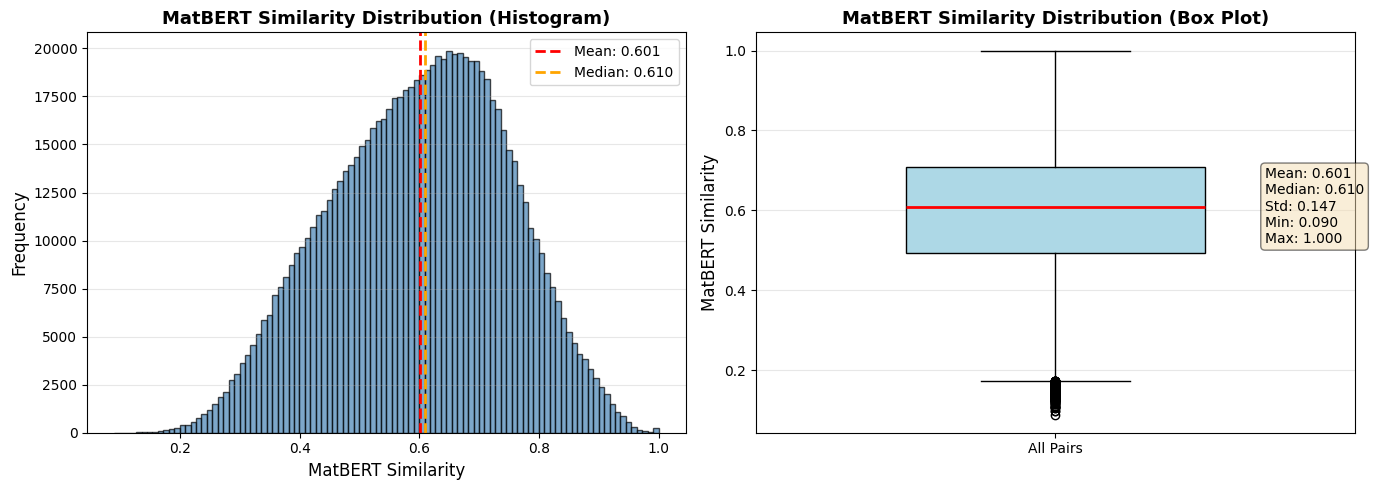

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
df = pd.read_csv('roberta_topk_neighbors.csv')

print(f"Total token pairs: {len(df):,}")
print(f"\n=== MatBERT Similarity Statistics ===")
print(df['sim_matbert'].describe())
print(f"\nQuantiles:")
for q in [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
    val = df['sim_matbert'].quantile(q)
    print(f"  {q*100:5.1f}%: {val:.4f}")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['sim_matbert'], bins=100, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(df['sim_matbert'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["sim_matbert"].mean():.3f}')
axes[0].axvline(df['sim_matbert'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {df["sim_matbert"].median():.3f}')
axes[0].set_xlabel('MatBERT Similarity', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('MatBERT Similarity Distribution (Histogram)', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Box plot
bp = axes[1].boxplot([df['sim_matbert']], vert=True, patch_artist=True, widths=0.5)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][0].set_edgecolor('black')
bp['medians'][0].set_color('red')
bp['medians'][0].set_linewidth(2)

# Add statistics text
stats_text = f"Mean: {df['sim_matbert'].mean():.3f}\n"
stats_text += f"Median: {df['sim_matbert'].median():.3f}\n"
stats_text += f"Std: {df['sim_matbert'].std():.3f}\n"
stats_text += f"Min: {df['sim_matbert'].min():.3f}\n"
stats_text += f"Max: {df['sim_matbert'].max():.3f}"

axes[1].text(1.35, df['sim_matbert'].median(), stats_text, 
             fontsize=10, verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[1].set_ylabel('MatBERT Similarity', fontsize=12)
axes[1].set_title('MatBERT Similarity Distribution (Box Plot)', fontsize=13, fontweight='bold')
axes[1].set_xticks([1])
axes[1].set_xticklabels(['All Pairs'])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('matbert_similarity_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

/tmp/ipykernel_278330/1844469256.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0, 1].boxplot([df['sim_roberta'], df['sim_matbert']],


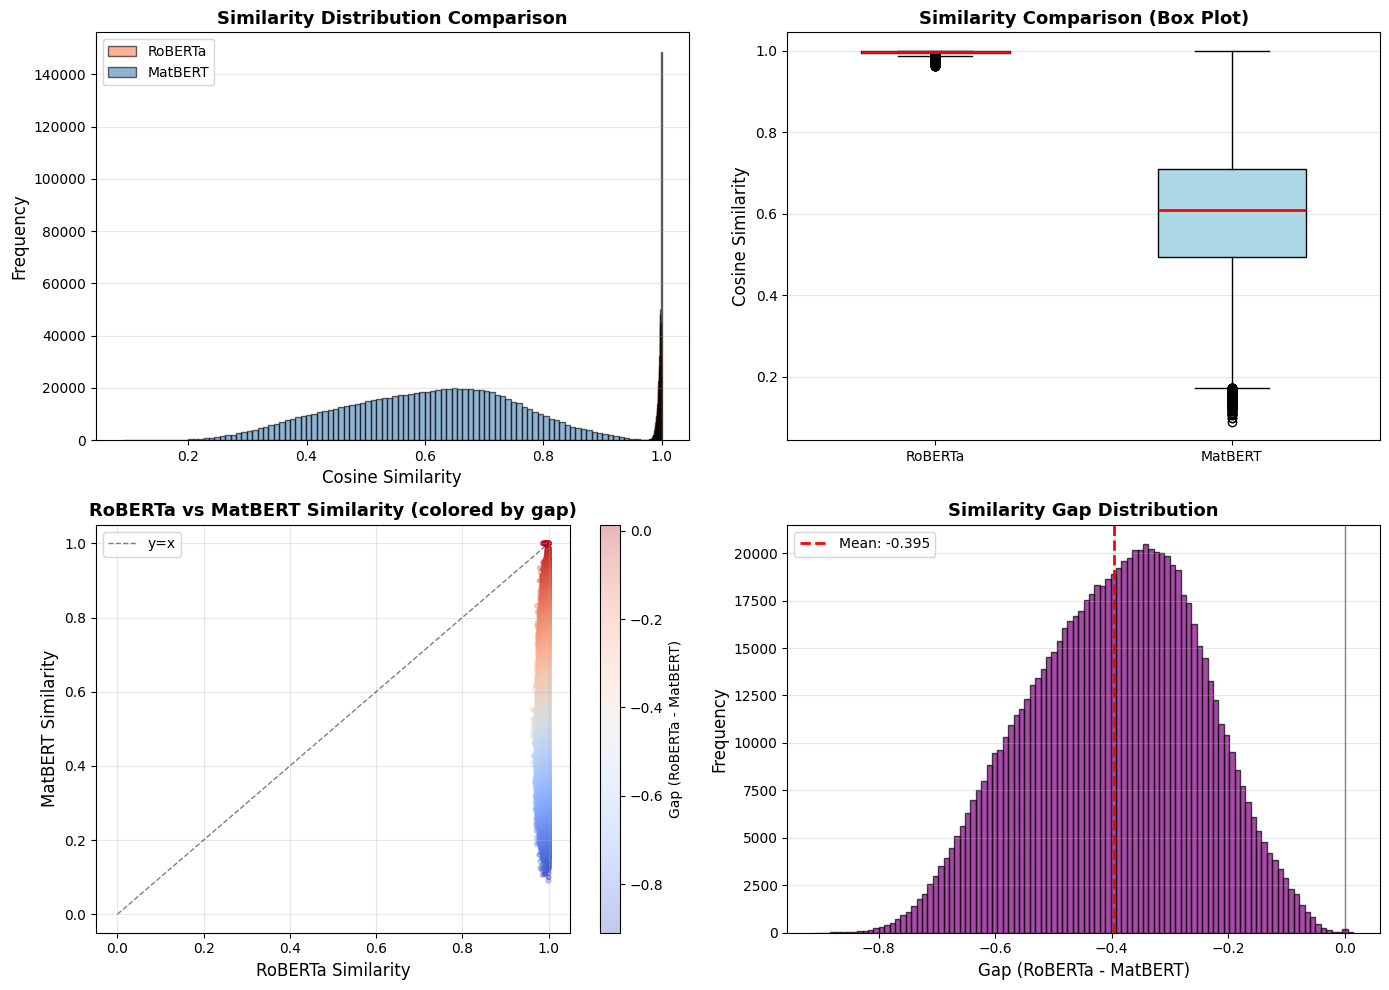


=== Comparison Statistics ===
RoBERTa mean: 0.9961, std: 0.0037
MatBERT mean: 0.6007, std: 0.1472
Gap mean: -0.3954, std: 0.1459

Pairs where RoBERTa > MatBERT: 259 (0.0%)
Pairs where MatBERT > RoBERTa: 850,241 (100.0%)


In [4]:
# Compare MatBERT vs RoBERTa similarities
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Overlapping histograms
axes[0, 0].hist(df['sim_roberta'], bins=100, color='coral', alpha=0.6, label='RoBERTa', edgecolor='black')
axes[0, 0].hist(df['sim_matbert'], bins=100, color='steelblue', alpha=0.6, label='MatBERT', edgecolor='black')
axes[0, 0].set_xlabel('Cosine Similarity', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Similarity Distribution Comparison', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Side-by-side box plots
bp = axes[0, 1].boxplot([df['sim_roberta'], df['sim_matbert']], 
                        labels=['RoBERTa', 'MatBERT'],
                        patch_artist=True, widths=0.5)
bp['boxes'][0].set_facecolor('coral')
bp['boxes'][1].set_facecolor('lightblue')
for box in bp['boxes']:
    box.set_edgecolor('black')
for median in bp['medians']:
    median.set_color('red')
    median.set_linewidth(2)
axes[0, 1].set_ylabel('Cosine Similarity', fontsize=12)
axes[0, 1].set_title('Similarity Comparison (Box Plot)', fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Scatter plot: RoBERTa vs MatBERT
scatter = axes[1, 0].scatter(df['sim_roberta'], df['sim_matbert'], 
                             c=df['gap'], cmap='coolwarm', alpha=0.3, s=10)
axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1, label='y=x')
axes[1, 0].set_xlabel('RoBERTa Similarity', fontsize=12)
axes[1, 0].set_ylabel('MatBERT Similarity', fontsize=12)
axes[1, 0].set_title('RoBERTa vs MatBERT Similarity (colored by gap)', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[1, 0])
cbar.set_label('Gap (RoBERTa - MatBERT)', fontsize=10)

# Gap distribution
axes[1, 1].hist(df['gap'], bins=100, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(df['gap'].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {df["gap"].mean():.3f}')
axes[1, 1].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[1, 1].set_xlabel('Gap (RoBERTa - MatBERT)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Similarity Gap Distribution', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('similarity_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Print comparison statistics
print("\n=== Comparison Statistics ===")
print(f"RoBERTa mean: {df['sim_roberta'].mean():.4f}, std: {df['sim_roberta'].std():.4f}")
print(f"MatBERT mean: {df['sim_matbert'].mean():.4f}, std: {df['sim_matbert'].std():.4f}")
print(f"Gap mean: {df['gap'].mean():.4f}, std: {df['gap'].std():.4f}")
print(f"\nPairs where RoBERTa > MatBERT: {(df['gap'] > 0).sum():,} ({(df['gap'] > 0).sum() / len(df) * 100:.1f}%)")
print(f"Pairs where MatBERT > RoBERTa: {(df['gap'] < 0).sum():,} ({(df['gap'] < 0).sum() / len(df) * 100:.1f}%)")

In [5]:
# Show examples of high gap pairs (RoBERTa high, MatBERT low)
print("\n=== Top 20 Pairs: RoBERTa High, MatBERT Low (High Gap) ===")
high_gap = df.nlargest(20, 'gap')[['token', 'neighbor', 'sim_roberta', 'sim_matbert', 'gap']]
print(high_gap.to_string(index=False))

print("\n=== Top 20 Pairs: MatBERT High, RoBERTa Low (Low Gap) ===")
low_gap = df.nsmallest(20, 'gap')[['token', 'neighbor', 'sim_roberta', 'sim_matbert', 'gap']]
print(low_gap.to_string(index=False))


=== Top 20 Pairs: RoBERTa High, MatBERT Low (High Gap) ===
       token     neighbor  sim_roberta  sim_matbert      gap
      VTOTAL       vtotal     0.986097     1.000000 0.013903
     NICOLET      NiCOLET     0.986912     1.000000 0.013088
      DRIFTS       DRIFTs     0.989042     1.000000 0.010958
      comsol       COMSOL     0.989466     1.000000 0.010534
MICROMETRICS micrometrics     0.989513     1.000000 0.010487
      ECOPIA       ECOPiA     0.989841     1.000000 0.010159
    digidrop     DIGIDROP     0.990129     1.000000 0.009871
        AISE         AISe     0.990240     1.000000 0.009760
 novocontrol  NOVOCONTROL     0.990431     1.000000 0.009569
        GMbH         GmBH     0.990565     1.000000 0.009435
      HIPIMS       HIPIMs     0.990716     1.000000 0.009283
       IVIUM        ivium     0.991113     1.000000 0.008887
        GMbH         GMBH     0.991880     1.000000 0.008120
       H10Ks        H10KS     0.992181     1.000000 0.007819
        PrGO         PRGO